Implement the Adaline with SGD which can set different batch_size ( M ) as parameter. Then, use the Iris dataset to fit your model with 3 different  M  (including  M=1 ) and fixed learning rate  η  and print out the accuracy of each model. Last, plot the cost against the number of epochs using different  M  in one figure.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#Testing data points: 20
Class labels: [-1  1]


In [2]:
seed = np.random.seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, batch_size=1): # 
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.batch_size = batch_size # add M
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            # iterate len(X) // self.batch_size times
            for idx in range(len(X) // self.batch_size):
                xi = X[idx * self.batch_size : (idx + 1) * self.batch_size]
                yi = y[idx * self.batch_size : (idx + 1) * self.batch_size]
                cost.append(self._update_weights(xi, yi))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = sum(0.5 * error**2) # sum
        
        # Update rule
        for idx in range(len(xi)):
            self.w_[1:] += self.eta * xi[idx].dot(error[idx])
        self.w_[0] += sum(self.eta * error) # sum
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

In [3]:
# Test
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=4, batch_size=3)  #  
adas.fit(X_train_std, y_train)

In [4]:
adas.cost_

[0.2539449909338076,
 0.14130519243741074,
 0.1295413813764673,
 0.12886254496127736,
 0.1334794388415538,
 0.13436081245330161,
 0.12809727915753516,
 0.13280556343828304,
 0.1333407577502299,
 0.13306954732192441,
 0.13016649131413677,
 0.13200451308415212,
 0.12404298420896702,
 0.13162182946544793,
 0.13182232917585332,
 0.12769363222059288,
 0.13358929878023984,
 0.13377856513097247,
 0.12461675131776799,
 0.13265749426032408]

In [5]:
from sklearn.metrics import accuracy_score

# Try with different batch size
batch_size_arr = [1, 2, 20, 80]

adas_arr = []
for batch_size in batch_size_arr:
    adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1, batch_size=batch_size)
    adas.fit(X_train_std, y_train)
    adas_arr.append(adas)
    
    # print out accuracy of Testing data
    y_pred = adas.predict(X_test_std)
    print('Batch size = %d' % batch_size)
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))
    

Batch size = 1
Misclassified samples: 3
Accuracy: 0.85

Batch size = 2
Misclassified samples: 3
Accuracy: 0.85

Batch size = 20
Misclassified samples: 3
Accuracy: 0.85

Batch size = 80
Misclassified samples: 3
Accuracy: 0.85



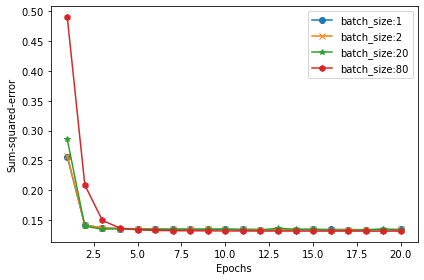

In [6]:
# Visualization
import matplotlib.pyplot as plt

markers = ['o', 'x', '*', 'h', 'D']

for i in range(len(adas_arr)): 
    # Cost values
    plt.plot(range(1, len(adas_arr[i].cost_) + 1), adas_arr[i].cost_, 
             marker=markers[i], label=f'batch_size:{batch_size_arr[i]}')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()